In [2]:
import warnings
warnings.simplefilter(action='ignore')

import logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

In [3]:
import os
import json
import pandas as pd
import geopandas as gpd
from io import BytesIO
from datetime import datetime
from arcgis.gis import GIS

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [4]:
logging.basicConfig(level=logging.INFO, format='%(message)s')

In [16]:
# inputs
wks= r'Q:\dss_workarea\mlabiadh\workspace\20241015_Park_assets_script'
f_assets= os.path.join(wks, 'data', 'PARC_citywide_export.xlsx')
f_trails= os.path.join(wks, 'data', 'trails.shp')

In [6]:
# read the assets xlsx into a df
df= pd.read_excel(f_assets)
df.shape

(103681, 13)

In [7]:
# make GIS-friendly column names
#df.columns = df.columns.str.replace(' - ', '_').str.replace(' ', '_')
df.columns

Index(['Asset ID', 'GIS ID', 'Park', 'Park Subarea',
       'Category - Classification', 'Segment - Sub Classification',
       'Description', 'Campsite Number', 'Name', 'acs Is Asset Accessible',
       'acs Is the Route to the Asset Accessible', 'GIS Latitude',
       'GIS Longitude'],
      dtype='object')

In [8]:
# remove rows with missing coordinates
df = df.dropna(subset=['GIS Latitude', 'GIS Longitude'])
df.shape

(103496, 13)

In [9]:
# check for out-of-range coordinates
lat_min, lat_max = 47, 60
lon_min, lon_max = -145, -113

outside_bc = df[
    (df['GIS Latitude'] < lat_min) | (df['GIS Latitude'] > lat_max) |
    (df['GIS Longitude'] < lon_min) | (df['GIS Longitude'] > lon_max)
]

outside_bc.shape


(0, 13)

In [10]:
# convert to geodataframe
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['GIS Longitude'], df['GIS Latitude']),
    crs="EPSG:4326"
)
gdf.shape

(103496, 14)

In [11]:
# convert object cols to strings (objects not supported by fiona)
gdf = gdf.astype(
    {col: 'str' for col in gdf.select_dtypes(include=['object']).columns}
    )
gdf.dtypes

Asset ID                                       int64
GIS ID                                        object
Park                                          object
Park Subarea                                  object
Category - Classification                     object
Segment - Sub Classification                  object
Description                                   object
Campsite Number                               object
Name                                          object
acs Is Asset Accessible                       object
acs Is the Route to the Asset Accessible      object
GIS Latitude                                 float64
GIS Longitude                                float64
geometry                                    geometry
dtype: object

In [17]:
# read the trails shapefile
gdf_tr= gpd.read_file(f_trails)

Found credentials in environment variables.
Found credentials in environment variables.


In [18]:
gdf_tr.columns

Index(['ogc_fid', 'assetid', 'gisid', 'asset_cate', 'asset_type', 'park',
       'park_subar', 'trail_surf', 'length_m', 'trail_name', 'osmid',
       'descriptio', 'verified_b', 'accessible', 'route_acce', 'geometry'],
      dtype='object')

In [20]:
# rename Trails columns to match with Assets dataset (if matches!) and/or assign readable names
gdf_tr= gdf_tr.rename(
            columns={"assetid": "Asset ID", 
                    "gisid": "GIS ID",
                    "asset_cate": "Category - Classification",
                    "asset_type": "Asset Type",
                    "park": "Park",
                    "park_subar": "Park Subarea",
                    "trail_surf": "Trail Surface",
                    "length_m": "Length Meters",
                    "trail_name": "Trail Name",
                    "osmid": "OSM ID",
                    "descriptio": "Description",
                    "verified_b": "Verified By",
                    "accessible": "Is Accessible",
                    "route_acce": "Is Route Accessible",
                    }
        )

In [38]:
# reproject trails gdf to wgs84
gdf_tr= gdf_tr.to_crs(4326)
gdf_tr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
# connect to AGOL
def connect_to_AGO (HOST, USERNAME, PASSWORD):
    """ 
    Connects to AGOL
    """     
    gis = GIS(HOST, USERNAME, PASSWORD)

    # Test if the connection is successful
    if gis.users.me:
        logging.info(f'..successfully connected to AGOL as {gis.users.me.username}')
    else:
        logging.error('..connection to AGOL failed.')
    
    return gis


AGO_HOST = os.getenv('AGO_HOST')
AGO_USERNAME = os.getenv('AGO_USERNAME_ML')
AGO_PASSWORD = os.getenv('AGO_PASSWORD_ML')

gis = connect_to_AGO(AGO_HOST, AGO_USERNAME, AGO_PASSWORD)

..successfully connected to AGOL as MLABIADH.BC


In [41]:
def publish_feature_layer(gis, gdf, title, geojson_name, item_desc, folder):
    """
    Publishes a gdf to AGO as Feature Layer, overwriting if it already exists.
    """
    #format null values
    gdf = gdf.replace(['nan'], '')

    logging.info(f"..converting data to geojson.")
    def gdf_to_geojson(gdf):
            features = []
            for _, row in gdf.iterrows():
                feature = {
                    "type": "Feature",
                    "properties": {},
                    "geometry": row['geometry'].__geo_interface__
                }
                for column, value in row.items():
                    if column != 'geometry':
                        if isinstance(value, (datetime, pd.Timestamp)):
                            feature['properties'][column] = value.isoformat() if not pd.isna(value) else ''
                        else:
                            feature['properties'][column] = value
                features.append(feature)
            
            geojson_dict = {
                "type": "FeatureCollection",
                "features": features
            }
            return geojson_dict

    # Convert GeoDataFrame to GeoJSON
    geojson_dict = gdf_to_geojson(gdf)

    try:
        #search for an existing GeoJSON
        existing_items = gis.content.search(
            f"title:\"{title}\" AND owner:{gis.users.me.username}",
            item_type="GeoJson"
        )
        # if an existing GeoJSON is found, Delete it
        for item in existing_items:
            if item.type == 'GeoJson':
                item.delete(force=True, permanent=True)
                logging.info(f"..existing GeoJSON item '{item.title}' deleted.")

        # Create a new GeoJSON item
        geojson_item_properties = {
            'title': title,
            'type': 'GeoJson',
            'tags': 'BCparks data',
            'description': item_desc,
            'fileName': f'{geojson_name}.geojson'
        }
        geojson_file = BytesIO(json.dumps(geojson_dict).encode('utf-8'))
        new_geojson_item = gis.content.add(item_properties=geojson_item_properties, data=geojson_file, folder=folder)

        # Overwrite the existing feature layer or create a new one if it doesn't exist
        published_item = new_geojson_item.publish(overwrite=True)
        logging.info(f"..feature layer '{title}' published successfully.")

        return published_item


    except Exception as e:
        error_message = f"..error publishing/updating feature layer: {str(e)}"
        raise RuntimeError(error_message)

..converting data to geojson.
..existing GeoJSON item 'PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests' deleted.
..feature layer 'PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests' published successfully.


<Item title:"PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests" type:Feature Layer Collection owner:MLABIADH.BC>
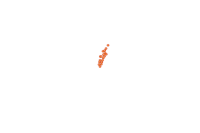

In [42]:
# publish the assets dataset to AGO
title= 'PARC_L1G_Park_Asset_Data_Feature_Layer_v2_tests'
folder= '2024_PARC'
geojson_name= 'assets'
item_desc= 'Point dataset - Park assets'

#gdf_test = gdf.head(2)
#print (gdf_test.shape)

#LayerID: 639540fc1e7c40c5a2954cdc3b4185da

publish_feature_layer(gis, gdf, title, geojson_name, item_desc, folder)

..converting data to geojson.
..existing GeoJSON item 'PARC_L1G_Park_Trails_Data_Feature_Layer_v2_tests' deleted.
..feature layer 'PARC_L1G_Park_Trails_Data_Feature_Layer_v2_tests' published successfully.


<Item title:"PARC_L1G_Park_Trails_Data_Feature_Layer_v2_tests" type:Feature Layer Collection owner:MLABIADH.BC>
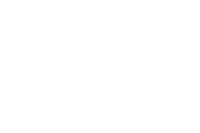

In [43]:
# publish the trails dataset to AGO
title= 'PARC_L1G_Park_Trails_Data_Feature_Layer_v2_tests'
folder= '2024_PARC'
geojson_name= 'trails'
item_desc= 'Line dataset - Park trails'

#gdf_tr_test = gdf_tr.head(2)
#print (gdf_tr_test.shape)

#LayerID: dc74c1c3ed8842c5b919e475286a761e

publish_feature_layer(gis, gdf_tr, title, geojson_name, item_desc, folder)